# Assignment 2 - D7046E
In this notebook I'll go through the steps I took to replicate the [Utilizing big data analytics for information systems
research: challenges, promises and guidelines](https://link.springer.com/article/10.1057/ejis.2016.2) study. As well as some analysis of how my result compare to the paper.

## Student info
Name: Anton Sandin\
Student ID: sanano-1\
E-mail: sanano-1@student.ltu.se

## Assignment Code

### Code for reading the json file

In [ ]:
import json

# Number of reviews to import
data_length = 100000

# Iterate thorugh file and add to list
data=[]
with open('Game_reviews.json', 'r') as file:
    for i, line in enumerate(file):
        if i == data_length:
            break
        data.append(json.loads(line))

### Code for downloading and creating stopwords

In [162]:
# Download stopwords if not downloaded
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [163]:
# Load english stopwords and add a few gaming related words like in the paper.
from nltk.corpus import stopwords
stopwords = stopwords.words("english")
stopwords = stopwords+["game","gaming","play","videogame"]
stopwords = set(stopwords)
print(stopwords)

{'as', 'if', 're', 'their', 'just', 'off', 'at', 'doing', 'here', 'other', 'does', 'such', 'then', 'y', 'game', 'by', 'because', 'for', 'in', 'why', "isn't", 'ourselves', "doesn't", 'isn', 'again', 'couldn', 'with', 'not', "shouldn't", 've', 'each', 'she', 'when', 'himself', 'don', 't', 'are', 'more', "you're", 'a', 'and', 'doesn', 'wouldn', 'all', 'while', 'hadn', 'over', 'hers', 'you', "that'll", 'too', 'do', 'some', 'did', "won't", 'won', 'from', 'above', 'same', 'is', 'but', 'an', 'between', 'under', 'mightn', "needn't", 'his', "don't", "mightn't", 'herself', 'them', 'now', 'that', 'or', 'having', 'how', "haven't", 'through', "you'd", 'm', 'aren', 'haven', 'am', 'further', "wasn't", 'who', 'gaming', 'him', 'mustn', 'yourself', 'against', 'to', 'shan', "wouldn't", 'being', 'any', 'videogame', "couldn't", 'down', 'shouldn', 'themselves', 'no', "didn't", 'on', 'be', 'nor', 'myself', 'own', 'of', 'll', 'they', 'have', 'd', 'very', 'so', 'once', "it's", 'ours', 'there', 'than', 'only', 

### Code for preprocessing

In [164]:
import spacy
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(text, tags=["NOUN", "ADJ", "VERB", "ADV"]):
    """
    Function that lemmatizes the text using the spacy en_core_web_sm package, and removes some word types.
    """
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in tags:
            new_text.append(token.lemma_)
    out_text = " ".join(new_text)
    return out_text

def remove_stopwords(text_tokens):
    return [w for w in text_tokens if not w.lower() in stopwords]

def pre_process_text(text):
    """
    Wrapping function for preprocessing.
    """
    text = lemmatization(text)
    text = simple_preprocess(text, deacc=True)
    text = remove_stopwords(text)

    return text

def format_text(data):
    """
    Creates feature and label lists, removes samples that are neither helpful or unhelpfull 1 or less difference.
    """
    features = []
    labels = []
    for d in data:
        # good_reviews - bad_reviews = (good_reviews - (total_reviews - good_reviews)) = 2*good_reviews - total_reviews
        helpful = 2*d['helpful'][0]-d['helpful'][1]

        # remove neither good or bad
        if abs(helpful) <= 1:
            continue

        # adds to lists.
        features.append([pre_process_text(d['reviewText']),pre_process_text(d['summary']),d['overall'],len(d['reviewText'])])
        labels.append(int(helpful>0))
        
    return (features, labels)

data, labels = format_text(data)

print("Example feature and label.")
print("Feature:")
print(data[0])
print("Label:")
print(labels[0])

Example feature and label.
Feature:
[['lease', 'owner', 'small', 'business', 'distribute', 'purchase', 'program', 'relate', 'stuff', 'see', 'pleasantly', 'surprised', 'exercise', 'allow', 'run', 'business', 'restock', 'consider', 'expense', 'win', 'loose', 'day', 'business', 'depend', 'decision', 'great', 'tool', 'teach', 'kid', 'business', 'responsibility', 'also', 'fun'], ['teach', 'adult'], 4.0, 579]
Label:
1


### Code for train/test sets splits
In this section I create a train and test set. (I didn't include a validation set since the paper didn't and there aren't too many hyperparameters to tune)

In [165]:
import random

#train test splits
train_split = 0.8
seed = 1234

random.Random(seed).shuffle(data)
random.Random(seed).shuffle(labels)

print(f"Length of total dataset {len(data)}.")

train_data = data[:round(len(data)*train_split)]
test_data = data[round(len(data)*train_split):]
train_label = labels[:round(len(data)*train_split)]
test_label = labels[round(len(data)*train_split):]

print(f"Length of train dataset {len(train_data)}.")
print(f"Length of test dataset {len(test_data)}.")

Length of total dataset 36604.
Length of train dataset 29283.
Length of test dataset 7321.


### Code for creating BoW (Bag of Words) corpus

In [166]:
def get_txt(dataset,type=None):
    """
    Takes the text data from our features and turns it into a list.

    Input: [[text1, summary1, stars, length], [text2, summary2, stars, length], [text3, summary3, stars, length], ...]
    Output (for this application type==all): [text1+summary1, text2+summary2, text3+summary3, ...]  
    """
    if type is None:
        i = 0
        return [e[i] for e in dataset]
    elif type == "summary":
        i = 1
        return [e[i] for e in dataset]
    elif type == "all":
        return [e[0]+e[1] for e in dataset]
    raise Exception

In [167]:
# Id to word mapping
id2word = corpora.Dictionary(get_txt(train_data,type="all"))

def create_bow(data):
    """
    Function to create BoW
    """
    corpus = []
    for text in data:
        new = id2word.doc2bow(text)
        corpus.append(new)
    return corpus

# Create corpus BoW from training data
train_corpus=create_bow(get_txt(train_data,type="all"))

### Create a LDA (Latent Dirichlet allocation) model

In [168]:
from gensim.models.ldamodel import LdaModel

# Create a LDA model
lda_model = LdaModel(corpus=train_corpus,
                     id2word=id2word,
                     random_state=50,
                     num_topics=40,
                     update_every=1,
                     chunksize=50,
                     passes=1,
                     alpha="auto")

# Show some topics to see if its working.
lda_model.show_topics(num_topics=10, num_words=10, log=False, formatted=True)

[(3,
  '0.000*"frommojo" + 0.000*"babbler" + 0.000*"inhumanly" + 0.000*"toughest" + 0.000*"xenomorph" + 0.000*"unlikeliness" + 0.000*"hugger" + 0.000*"costemer" + 0.000*"sratch" + 0.000*"hyperbolic"'),
 (35,
  '0.000*"frommojo" + 0.000*"babbler" + 0.000*"inhumanly" + 0.000*"toughest" + 0.000*"xenomorph" + 0.000*"unlikeliness" + 0.000*"hugger" + 0.000*"costemer" + 0.000*"sratch" + 0.000*"hyperbolic"'),
 (6,
  '0.000*"frommojo" + 0.000*"babbler" + 0.000*"inhumanly" + 0.000*"toughest" + 0.000*"xenomorph" + 0.000*"unlikeliness" + 0.000*"hugger" + 0.000*"costemer" + 0.000*"sratch" + 0.000*"hyperbolic"'),
 (9,
  '0.634*"screen" + 0.066*"coaster" + 0.000*"frommojo" + 0.000*"inhumanly" + 0.000*"toughest" + 0.000*"xenomorph" + 0.000*"unlikeliness" + 0.000*"hugger" + 0.000*"costemer" + 0.000*"sratch"'),
 (27,
  '0.388*"monster" + 0.202*"send" + 0.132*"depend" + 0.026*"info" + 0.000*"certain" + 0.000*"different" + 0.000*"sratch" + 0.000*"unlikeliness" + 0.000*"xenomorph" + 0.000*"dogfighing"'),
 

### Various preprocessing steps
Turning text to topic vectors, lists to numpy, normalization and such.

In [169]:
def topic_word_list(list_words):
    """
    Function for turning lda probablitites to an feature vector.
    """
    vec = [0]*lda_model.num_topics
    probabilities = lda_model.get_document_topics(id2word.doc2bow(list_words))
    for i, p in probabilities:
        vec[i]=p
    return vec

In [170]:
def numericalize_data(features):
    """
    Function to turn text data to numerical form using our LDA model.
    """
    new_features = []
    for f in features:
        new_features.append(topic_word_list(f[0])+topic_word_list(f[1])+[f[2]]+[f[3]])
    return new_features

# Numricalize train/test data
train_data = numericalize_data(train_data)
test_data = numericalize_data(test_data)

feature_names = []
topic_ids = []
for i in range(lda_model.num_topics):
    feature_names.append("Topic " + str(i))
    topic_ids.append(i)
for i in range(lda_model.num_topics):
    feature_names.append("Topic (S) " + str(i))
    topic_ids.append(i)
feature_names = feature_names + ["Stars","Length"]

In [171]:
print("Example Feature:")
print(train_data[0])
print("Example label:")
print(train_label[0])

Example Feature:
[0.01417105, 0, 0.018037474, 0, 0, 0, 0, 0, 0.0103240255, 0, 0, 0, 0, 0, 0.034291945, 0.045148138, 0.26440603, 0, 0.029121231, 0, 0, 0.028817097, 0, 0, 0, 0, 0, 0, 0.0119284745, 0, 0, 0, 0, 0.01170677, 0.03159436, 0, 0.019673439, 0.01354891, 0.10098476, 0.24397497, 0.01757276, 0.0113235945, 0.022352219, 0, 0.011631979, 0, 0, 0, 0.012795112, 0, 0, 0, 0, 0, 0.042521745, 0.013629717, 0.25548562, 0, 0, 0.010254849, 0.010894384, 0.021638982, 0, 0, 0, 0, 0, 0, 0.014800735, 0.012306402, 0, 0, 0, 0.014516938, 0.024988113, 0, 0.010274582, 0.016801277, 0.10198982, 0.27114022, 4.0, 241]
Example label:
1


In [172]:
import numpy as np

# Turn list data to numpy
train_features_non_normalized = np.array(train_data)
train_labels = np.array(train_label)
test_features_non_normalized = np.array(test_data)
test_labels = np.array(test_label)

In [173]:
# normalize train and test set using the mean and std from training set to avoid data leakage.
mean = np.mean(train_features_non_normalized,0)
std = np.std(train_features_non_normalized,0)

# Avoid divide by zero
std[std==0]=1

test_features = (test_features_non_normalized-mean)/std
train_features = (train_features_non_normalized-mean)/std

### Create and train Random Forest Classifier

In [174]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1,n_estimators=128)
clf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=128, random_state=1)

### Test model performance

In [175]:
# Get accuracy
y_pred = clf.predict(test_features)
print(f"Accuracy: {(np.sum(test_labels == y_pred)/len(test_labels))*100}%")

Accuracy: 78.52752356235487%


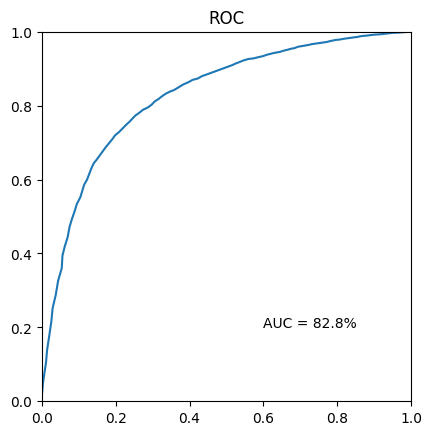

In [188]:
# Gets ROC and AUC

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

y_scores = clf.predict_proba(test_features)
y_true = test_labels

fpr, tpr, thresholds = roc_curve(y_true, y_scores[:,1])

plt.plot(fpr,tpr)
plt.title("ROC")
plt.text(0.6,0.2,f"AUC = {int(auc(fpr,tpr)*1000)/10}%")
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().set_aspect('equal', 'box')
plt.show()

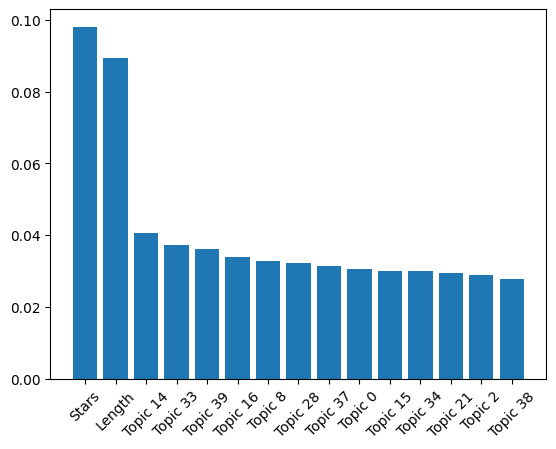

In [ ]:
importance = clf.feature_importances_

best_ind = np.argsort(importance)[-15:]

names=[]
imporances=[]
for ind in best_ind:
    names.append(feature_names[ind])
    imporances.append(importance[ind])

names.reverse()
imporances.reverse()

plt.bar(names, imporances)
plt.xticks(rotation=45)
plt.show()

In [178]:
ids = []

for ind in reversed(best_ind):
    if ind<len(topic_ids) and topic_ids[ind] not in ids:
        ids.append(topic_ids[ind])

print("Most important topics:")
for id in ids:
    print("Topic ID " + str(id) + ": " + str([id2word[tup[0]] for tup in lda_model.get_topic_terms(id, topn=10)]))

Most important topics:
Topic ID 14: ['good', 'ever', 'bad', 'action', 'gamer', 'wait', 'guy', 'buy', 'full', 'shooter']
Topic ID 33: ['life', 'true', 'write', 'main', 'believe', 'box', 'half', 'notice', 'funny', 'cheap']
Topic ID 39: ['get', 'time', 'go', 'first', 'really', 'thing', 'even', 'buy', 'think', 'see']
Topic ID 16: ['fun', 'great', 'also', 'find', 'player', 'still', 'many', 'make', 'much', 'little']
Topic ID 8: ['quot', 'cool', 'man', 'mind', 'previous', 'code', 'guess', 'cheat', 'ok', 'trouble']
Topic ID 28: ['fan', 'realistic', 'awesome', 'race', 'multiplayer', 'ship', 'final', 'job', 'class', 'return']
Topic ID 37: ['story', 'quest', 'follow', 'building', 'bug', 'force', 'ending', 'hate', 'stay', 'boy']
Topic ID 0: ['set', 'change', 'allow', 'choose', 'party', 'require', 'question', 'ask', 'various', 'similar']
Topic ID 15: ['strategy', 'unit', 'fighter', 'live', 'ball', 'fall', 'range', 'tank', 'ground', 'family']
Topic ID 34: ['place', 'kill', 'classic', 'adventure', 's

## Results
Below is a summary of the results based on the questions provided in the assignment.

### Summarize your results (model performance, iterations if any) and compare them with the original study's results. It's okay if your model performs differently; just try to pinpoint the reason(s)!
We can see that my implementation achives a accuracy of about 78.5% and an AUC score at around 82.% which is somewhat higher than the AUC score in the paper at 73%. I think this is because I choose to also include the summary as features instead of what the paper has done (which I believe they didn't mentioned but if I were to guess might have been exluding it or combining it with the text description). 

Another difference from the papers result was that I found that the star rating was more important than the length of the review which was the opposite in the paper, I don't understand the cause of this but some possible reasons could be sampling bias from not me using the full dataset or implementation errors.

Finally there is a slight difference in the topics that were important, mine seems to focus on more broad concepts like good, bad, strategy, racing, etc. while the paper also focuses on brands like EA, Halo, and Call of duty which is not a pattern I see in my topics.

### Reflect on the task using the 3-2-1 prompt as follows: Mention 3 things you learned, Pose 2 questions you still have, Mention 1 thing you enjoyed.

3 things I have learned:
- Latent Dirichlet Allocation (LDA): I had previously never hear about this approch to NLP but I think its a good way to extract features from texts in this statistical way, and gives a alternative between the classical/simple ways like n-grams and BoW, and the modern/complex methods like transformers.
- ROC/AUC: Previously I had only heard about these metrics but didn't really understand them, now that I do I think ROC is a great way to visualize the performance of a model and AUC is a better metric than accuracy since it compares models across different thresholds, is more fair with imbalanced datascine it is based on sensitivity and specificity.
- Random forest normalization: I also learned something that maybe should have been obvious, namely that random forest classifiers doesn't need normalization. In my code I normalized my features to avoid scaling differences between features but since random forest uses information gains as a spliting metric this wasn't accualy nessesary.

2 questions I still have:
- Why did me and the paper not get the same result about the relative importance of length and star rating.
- What would change if we change the LDA and/or the Random Forest? Would a SVM be better? Which is more important, Is the LDA feature extraction or the Random Forest the bottleneck to improved performace?

1 thing I enjoyed:
- I enjoyed learning about new methods for text mining and evalutaion metrics, I found it really rewarding to learn about these methods and expect I will make great use of them in the future.

### Use of AI tools. If you use AI tools, then describe in what way you have used them. 
No AI tools were used in the making of this project.
